Igor Sudin MADE-ML-22

Второе домашнее задание — самое большое в курсе, в нём придётся и концептуально подумать о происходящем, и технические трудности тоже порешать. Как и раньше, в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Как всегда, любые комментарии, новые идеи и рассуждения на тему категорически приветствуются.


Второе задание — это полноценный проект по анализу данных, начиная от анализа постановки задачи и заканчивая сравнением результатов разных моделей. Задача реальная и серьёзная, хотя тему я выбрал развлекательную: мы будем строить вероятностную рейтинг-систему для спортивного “Что? Где? Когда?” (ЧГК).


Background: в спортивном “Что? Где? Когда?” соревнующиеся команды отвечают на одни и те же вопросы. После минуты обсуждения команды записывают и сдают свои ответы на карточках; побеждает тот, кто ответил на большее число вопросов. Турнир обычно состоит из нескольких десятков вопросов (обычно 36 или 45, иногда 60, больше редко). Часто бывают синхронные турниры, когда на одни и те же вопросы отвечают команды на сотнях игровых площадок по всему миру, т.е. в одном турнире могут играть сотни, а то и тысячи команд. Соответственно, нам нужно:
* построить рейтинг-лист, который способен нетривиально предсказывать результаты будущих турниров;
* при этом, поскольку ЧГК — это хобби, и контрактов тут никаких нет, игроки постоянно переходят из команды в команду, сильный игрок может на один турнир сесть поиграть за другую команду и т.д.; поэтому единицей рейтинг-листа должна быть не команда, а отдельный игрок;
* а что сильно упрощает задачу и переводит её в область домашних заданий на EM-алгоритм — это характер данных: начиная с какого-то момента, в базу результатов начали вносить все повопросные результаты команд, т.е. в данных будут записи вида “какая команда на какой вопрос правильно ответила”.


Я сделал за вас только первый шаг: выкачал через API сайта [рейтинга ЧГК](https://rating.chgk.info/) все нужные данные, чтобы сайт не прилёг под вашими многочисленными скрейперами. :) Полученные данные лежат в формате pickle вот здесь:
https://www.dropbox.com/s/s4qj0fpsn378m2i/chgk.zip 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
import json
import math
import time
import scipy
import optuna
import pandas as pd
from typing import Tuple
from collections import Counter
from datetime import datetime
from tqdm.notebook import tqdm
from sklearn.linear_model import LogisticRegression
from copy import deepcopy
from scipy.sparse import lil_matrix, vstack, hstack
from scipy.stats import spearmanr, kendalltau

import logging
import sys

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

TRAIN_YEAR = 2019
TEST_YEAR = 2020

PLAYERS_DATAPATH = "players.pkl"
RESULTS_DATAPATH = "results.pkl"
TOURNAMENTS_DATAPATH = "tournaments.pkl"

In [ ]:
# for colab
# !wget https://www.dropbox.com/s/s4qj0fpsn378m2i/chgk.zip -nc
# !unzip chgk.zip

In [ ]:
players_data = pickle.load(open(PLAYERS_DATAPATH, 'rb'))
results = pickle.load(open(RESULTS_DATAPATH, 'rb'))
tournaments = pickle.load(open(TOURNAMENTS_DATAPATH, 'rb'))

### Task 1

Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl). Для унификации предлагаю:

* взять в тренировочный набор турниры с dateStart из 2019 года; 
* в тестовый — турниры с dateStart из 2020 года.


#### Вывод данных и некоторые наблюдения

In [ ]:
tournaments[1]

{'id': 1,
 'name': 'Чемпионат Южного Кавказа',
 'dateStart': '2003-07-25T00:00:00+04:00',
 'dateEnd': '2003-07-27T00:00:00+04:00',
 'type': {'id': 2, 'name': 'Обычный'},
 'season': '/seasons/1',
 'orgcommittee': [],
 'synchData': None,
 'questionQty': None}

In [ ]:
df_tournaments = pd.DataFrame.from_dict(tournaments, orient='index').set_index("id")
df_tournaments.head(7)

,name,dateStart,dateEnd,type,season,orgcommittee,synchData,questionQty
id,,,,,,,,
1,Чемпионат Южного Кавказа,2003-07-25T00:00:00+04:00,2003-07-27T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/1,[],None,None
2,Летние зори,2003-08-09T00:00:00+04:00,2003-08-09T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/1,[],None,None
3,Турнир в Ижевске,2003-11-22T00:00:00+03:00,2003-11-24T00:00:00+03:00,"{'id': 2, 'name': 'Обычный'}",/seasons/2,[],None,None
4,Чемпионат Украины. Переходной этап,2003-10-11T00:00:00+04:00,2003-10-12T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/2,[],None,None
5,Бостонское чаепитие,2003-10-10T00:00:00+04:00,2003-10-13T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/2,[],None,None
6,Нестерка,2003-10-18T00:00:00+04:00,2003-10-19T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/2,[],None,None
7,"Фестиваль, посвящённый 60-летию ЮрГУ",2003-11-29T00:00:00+03:00,2003-11-30T00:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/2,[],None,None


In [ ]:
df_tournaments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5528 entries, 1 to 6485
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          5528 non-null   object
 1   dateStart     5528 non-null   object
 2   dateEnd       5528 non-null   object
 3   type          5528 non-null   object
 4   season        5434 non-null   object
 5   orgcommittee  5528 non-null   object
 6   synchData     1855 non-null   object
 7   questionQty   4343 non-null   object
dtypes: object(8)
memory usage: 388.7+ KB


In [ ]:
results[1]

[{'team': {'id': 242,
   'name': 'Команда Азимова',
   'town': {'id': 21, 'name': 'Баку'}},
  'mask': None,
  'current': {'name': 'Команда Азимова', 'town': {'id': 21, 'name': 'Баку'}},
  'questionsTotal': 0,
  'synchRequest': None,
  'position': 1,
  'controversials': [],
  'flags': [],
  'teamMembers': [{'flag': None,
    'usedRating': 0,
    'rating': 0,
    'player': {'id': 476,
     'name': 'Анар',
     'patronymic': 'Беюкага оглы',
     'surname': 'Азимов'}},
   {'flag': None,
    'usedRating': 0,
    'rating': 0,
    'player': {'id': 878,
     'name': 'Фариз',
     'patronymic': 'Наим оглы',
     'surname': 'Аликишибеков'}},
   {'flag': None,
    'usedRating': 0,
    'rating': 0,
    'player': {'id': 1872,
     'name': 'Аднан',
     'patronymic': 'Фариз оглы',
     'surname': 'Ахундов'}},
   {'flag': None,
    'usedRating': 0,
    'rating': 0,
    'player': {'id': 13721,
     'name': 'Балаш',
     'patronymic': 'Алекпер оглы',
     'surname': 'Касумов'}},
   {'flag': None,
    '

In [ ]:
list_of_masks = []
for key in results:
  for result in results[key]:
    if 'mask' in result.keys():
      if result["mask"] is not None:
        list_of_masks.append(set(result["mask"]))
Counter(list(map(str, list_of_masks)))

Counter({"{'0', '1'}": 355977,
         "{'0'}": 1634,
         "{'0', 'X', '1'}": 83319,
         "{'0', 'X'}": 353,
         "{'0', '?', '1'}": 81,
         "{'0', 'X', '?', '1'}": 25,
         "{'1'}": 17,
         "{'X', '1'}": 4})

#### Получение соревнований удовлетворяющих условиям

In [ ]:
# Получаем соревнования происходящие в нужные года
df_tournaments["dateStart"] = pd.to_datetime(df_tournaments["dateStart"])

df_tournaments_train = df_tournaments[df_tournaments["dateStart"].apply(lambda x: x.year) == TRAIN_YEAR]
df_tournaments_test = df_tournaments[df_tournaments["dateStart"].apply(lambda x: x.year) == TEST_YEAR]


In [ ]:
print("Train len:", len(df_tournaments_train))
print("Test len:", len(df_tournaments_test))

Train len: 687
Test len: 418


In [ ]:
df_tournaments_train.head(5)

,name,dateStart,dateEnd,type,season,orgcommittee,synchData,questionQty
id,,,,,,,,
4772,Синхрон северных стран. Зимний выпуск,2019-01-05 19:00:00+03:00,2019-01-09T19:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 28379, 'name': 'Константин', 'patronym...",{'dateRequestsAllowedTo': '2019-01-09T23:59:59...,"{'1': 12, '2': 12, '3': 12}"
4973,Балтийский Берег. 3 игра,2019-01-25 19:05:00+03:00,2019-01-29T19:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 23030, 'name': 'Марина', 'patronymic':...",{'dateRequestsAllowedTo': '2019-01-28T23:59:59...,"{'1': 12, '2': 12, '3': 12}"
4974,Балтийский Берег. 4 игра,2019-03-01 19:05:00+03:00,2019-03-05T19:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 23030, 'name': 'Марина', 'patronymic':...",{'dateRequestsAllowedTo': '2019-03-04T23:59:59...,"{'1': 12, '2': 12, '3': 12}"
4975,Балтийский Берег. 5 игра,2019-04-05 19:05:00+03:00,2019-04-09T19:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 23030, 'name': 'Марина', 'patronymic':...",{'dateRequestsAllowedTo': '2019-04-08T23:59:59...,"{'1': 12, '2': 12, '3': 12}"
4986,ОВСЧ. 6 этап,2019-02-15 20:00:00+03:00,2019-02-19T20:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/52,"[{'id': 59140, 'name': 'Борис', 'patronymic': ...",{'dateRequestsAllowedTo': '2019-02-19T23:59:59...,"{'1': 12, '2': 12, '3': 12}"


In [ ]:
df_tournaments_test.head(5)

,name,dateStart,dateEnd,type,season,orgcommittee,synchData,questionQty
id,,,,,,,,
4628,Семь сорок,2020-12-30 16:00:00+03:00,2020-12-30T16:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",None,"[{'id': 7533, 'name': 'Денис', 'patronymic': '...",{'dateRequestsAllowedTo': '2020-12-30T23:55:00...,"{'1': 12, '2': 12, '3': 12}"
4957,Синхрон Биркиркары,2020-02-21 00:00:00+03:00,2020-02-27T23:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/53,"[{'id': 2421, 'name': 'Ася', 'patronymic': 'Се...",{'dateRequestsAllowedTo': '2020-02-27T18:00:00...,"{'1': 13, '2': 13, '3': 13}"
5151,Яровой,2020-08-01 14:00:00+03:00,2020-08-05T14:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/53,"[{'id': 22325, 'name': 'Михаил', 'patronymic':...",{'dateRequestsAllowedTo': '2020-07-24T23:59:59...,"{'1': 12, '2': 12, '3': 12}"
5414,Синхрон северных стран,2020-01-03 19:00:00+03:00,2020-01-10T19:00:00+03:00,"{'id': 3, 'name': 'Синхрон'}",/seasons/53,"[{'id': 28379, 'name': 'Константин', 'patronym...",{'dateRequestsAllowedTo': '2020-01-10T23:59:00...,"{'1': 12, '2': 12, '3': 12}"
5477,Онлайн: Синхрон Урюбджирова,2020-04-18 19:00:00+03:00,2020-04-30T19:00:00+03:00,"{'id': 8, 'name': 'Асинхрон'}",/seasons/53,"[{'id': 91324, 'name': 'Эрдни', 'patronymic': ...",{'dateRequestsAllowedTo': '2020-04-30T23:55:00...,"{'1': 12, '2': 12, '3': 12}"


Получаем соревнования содержащие необходимые данные (о составах команд и повопросных результатах)

In [ ]:
# Странным является наличие соревнований, в которых различные команды отвечали на различное число вопросов, при этом
# предлагается заменить ответы вида ? и Х на 0 что будет наиболее логично и позволит "выровнять" количество вопросов в  
# некоторых соревнованиях.

count_with_remove = 0
count_with_negative = 0

for tournament_id in df_tournaments_train.index:
    tournament_results = results[tournament_id]
    total_questions_remove = set()
    total_questions_negative = set()    

    for team_result in tournament_results:
      if "mask" in team_result:
        if team_result["mask"] is not None:
          total_questions_remove.add(len(team_result['mask'].replace("?", "").replace("X", "")))
          total_questions_negative.add(len(team_result['mask'].replace("?", "0").replace("X", "0")))
    if len(total_questions_remove) > 1:
      count_with_remove += 1
    if len(total_questions_negative) > 1:
      count_with_negative += 1

print("Loss with negative coding:", count_with_negative)
print("Loss with removal coding:", count_with_remove)
    

Loss with negative coding: 12
Loss with removal coding: 23


In [ ]:
for tournament_id in df_tournaments_test.index:
    tournament_results = results[tournament_id]
    total_questions_remove = set()
    total_questions_negative = set()    

    for team_result in tournament_results:
      if "mask" in team_result:
        if team_result["mask"] is not None:
          total_questions_remove.add(len(team_result['mask'].replace("?", "").replace("X", "")))
          total_questions_negative.add(len(team_result['mask'].replace("?", "0").replace("X", "0")))
    if len(total_questions_remove) > 1:
      count_with_remove += 1
    if len(total_questions_negative) > 1:
      count_with_negative += 1

print("Loss with negative coding:", count_with_negative)
print("Loss with removal coding:", count_with_remove)

Loss with negative coding: 16
Loss with removal coding: 31


In [ ]:
def clear_tournaments(tournaments: pd.DataFrame) -> Tuple[pd.DataFrame, list]:
  """
  Получим пригодные соревнования соедержащие хотябы одно описание членов команды и хотябы одно заполненное поле оценок
  а так же оставим соревнования в которых содержатся только одинаковое количество вопросов для каждой из команд
  """
  good_tournaments_ids = []

  for tournament_id in tournaments.index:
    
    contain_mask = False
    contain_team_info = False
    set_questions_per_tour = set()

    tournament_results = results[tournament_id]
    for team_result in tournament_results:
      # проверка на наличие информации о команде
      if len(team_result['teamMembers']) > 0:
        contain_team_info = True
      # проверка на наличие информации о вопросах
      if 'mask' in team_result and team_result['mask']:
        contain_mask = True
      # проверка на однообразность количества вопросов
      if "mask" in team_result and team_result["mask"] is not None:
          set_questions_per_tour.add(len(team_result['mask'].replace("?", "0").replace("X", "0")))

    # добавляем индекс хорошего соревнования
    if len(set_questions_per_tour) == 1 and contain_mask and contain_team_info:
      good_tournaments_ids.append(tournament_id)

  good_tournaments = tournaments.copy(deep=True)
  good_tournaments = good_tournaments.iloc[good_tournaments.index.isin(good_tournaments_ids)]
  return good_tournaments, good_tournaments_ids

In [ ]:
df_tournaments_train_final, train_ind  = clear_tournaments(df_tournaments_train)
df_tournaments_test_final, test_ind  = clear_tournaments(df_tournaments_test)

print(len(train_ind))
print(len(test_ind))

663
169


#### Обернем это в финальную функцию для удобства

In [ ]:
def clear_tournaments(tournaments: pd.DataFrame) -> Tuple[pd.DataFrame, list]:
  """
  Получим пригодные соревнования соедержащие хотябы одно описание членов команды и хотябы одно заполненное поле оценок
  а так же оставим соревнования в которых содержатся только одинаковое количество вопросов для каждой из команд
  """
  good_tournaments_ids = []

  for tournament_id in tournaments.index:
    
    contain_mask = False
    contain_team_info = False
    set_questions_per_tour = set()

    tournament_results = results[tournament_id]
    for team_result in tournament_results:
      # проверка на наличие информации о команде
      if len(team_result['teamMembers']) > 0:
        contain_team_info = True
      # проверка на наличие информации о вопросах
      if 'mask' in team_result and team_result['mask']:
        contain_mask = True
      # проверка на однообразность количества вопросов
      if "mask" in team_result and team_result["mask"] is not None:
          set_questions_per_tour.add(len(team_result['mask'].replace("?", "0").replace("X", "0")))

    # добавляем индекс хорошего соревнования
    if len(set_questions_per_tour) == 1 and contain_mask and contain_team_info:
      good_tournaments_ids.append(tournament_id)

  good_tournaments = tournaments.copy(deep=True)
  good_tournaments = good_tournaments.iloc[good_tournaments.index.isin(good_tournaments_ids)]
  return good_tournaments, good_tournaments_ids


def get_tournaments_by_year(tournaments_dict: dict, year: int) -> Tuple[pd.DataFrame, list]:
  """
  Получаем "хорошие" турниры за определенный год
  """
  tournaments_df = pd.DataFrame.from_dict(tournaments_dict, orient='index').set_index("id")
  tournaments_df["dateStart"] = pd.to_datetime(tournaments_df["dateStart"])

  df_tournaments_year = tournaments_df[tournaments_df["dateStart"].apply(lambda x: x.year) == year]

  df_tournaments_year_clean, clean_ind = clear_tournaments(df_tournaments_year) 
  return df_tournaments_year_clean, clean_ind

In [ ]:
df_tournaments_train_final, train_ind  = get_tournaments_by_year(tournaments, TRAIN_YEAR)
df_tournaments_test_final, test_ind  = get_tournaments_by_year(tournaments, TEST_YEAR)

print(len(train_ind))
print(len(test_ind))

663
169


#### Получение обучающего и тестового наборов для дальнейших пунктов

In [ ]:
def get_set(tournaments_dataframe: pd.DataFrame) -> Tuple[list, list, list, dict]:
  """
  Получаем наборы данных необходимые для обучения и валидации
  """
  dataset = []
  all_players_ids = set()
  all_questions_ids = []

  for tournament_id in tqdm(tournaments_dataframe.index):
      tournament_data = {}
      tournament_data['id'] = tournament_id
      tournament_data["teams_data"] = []

      tournament_results = results[tournament_id]

      mask = ""

      for team_result in tournament_results:
        if ("mask" in team_result and  team_result["mask"] is not None and
            "teamMembers" in team_result and team_result["teamMembers"] != []
            ):
            tournament_data["n_questions"] = len(team_result["mask"])
          
            team_data = {}
            
            team_data['position'] = team_result['position']
            mask = team_result["mask"].replace("?", "0").replace("X","0")
            team_data["mask"] = list(map(int, mask))
            team_data["team_id"] = team_result["team"]["id"]
            team_data["players_id"] = []

            for player in team_result["teamMembers"]:
              team_data["players_id"].append(player["player"]["id"])
              all_players_ids.add(player["player"]["id"])

            team_data["n_players"] = len(team_data["players_id"])

            tournament_data["teams_data"].append(team_data)
      
      if mask:
        for i, _ in enumerate(mask):
          all_questions_ids.append(str(tournament_id) + '-' + str(i))

      dataset.append(tournament_data)

  all_players_ids = sorted(list(all_players_ids))

  player_id_index = {id : index for index, id in enumerate(all_players_ids)}

  return dataset, all_players_ids, all_questions_ids, player_id_index    

In [ ]:
train_set, train_players_ids, train_questions_ids, train_players_id_index = get_set(df_tournaments_train_final)
test_set, test_players_ids, test_questions_ids, test_players_id_index = get_set(df_tournaments_test_final)

  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

### Task 2


Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. Замечания и подсказки:
* повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;
* в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
* для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.


Для обучения модели линейной регресси будем использовать разреженную матрицу со столбцами соответствующими id игрока и id задачи. Каждая строка соотвествует тому что игрок i отвечал на вопрос j, т.е. в соотвествующих игроку и вопросу столбцах стоят единицы. Целевой переменной будет являться правильный или неправильный ответ на этот вопрос.

#### Получаем данные и обучаем модель

In [ ]:
def get_train_X_y(train_set, train_players_ids, train_questions_ids, train_players_id_index):
  """
  Строим разреженную матрицу и целевой вектор
  Создание матрицы требует большого объема оперативной памяти поэтому
  в google colab исполнение не представляется возможным
  """

  X_columns = len(train_players_ids) + len(train_questions_ids)
  X_rows = 0
  for tournament_data in train_set:
    for team_data in tournament_data["teams_data"]:
      X_rows += team_data["n_players"] * tournament_data["n_questions"]
  
  logging.info('Creating empty matrix...')
  start_time = time.time()

  X_train = lil_matrix((X_rows, X_columns), dtype=np.int8)
  y_train = np.zeros(X_rows)

  end_time = time.time()
  logging.info(f'Matrix created. {end_time - start_time}')
  logging.info('Filling matrix...')

  questions_shift = len(train_players_ids)
  n_row = 0

  for tournament_data in tqdm(train_set):
    for team_data in tournament_data["teams_data"]:
      for i_question in range(tournament_data["n_questions"]):
        true_y = team_data["mask"][i_question]
        question_idx = questions_shift + i_question
        for player_id in team_data['players_id']:
          i_player = train_players_id_index[player_id]
          X_train[n_row, i_player] = 1
          X_train[n_row, question_idx] = 1
          y_train[n_row] = true_y
          n_row += 1
    questions_shift += tournament_data["n_questions"]
  return X_train, y_train

In [ ]:
X_train, y_train = get_train_X_y(train_set, 
                                 train_players_ids, 
                                 train_questions_ids, 
                                 train_players_id_index)

2022-05-02 02:32:15,890 | INFO : Creating empty matrix...
2022-05-02 02:32:46,451 | INFO : Matrix created. 30.560033798217773
2022-05-02 02:32:46,452 | INFO : Filling matrix...


  0%|          | 0/663 [00:00<?, ?it/s]

In [ ]:
lr_model = LogisticRegression(solver='saga')
lr_model.fit(X_train, y_train)

LogisticRegression(solver='saga')

In [ ]:
players_raiting = lr_model.coef_[0][:len(train_players_ids)]
questions_complexity = lr_model.coef_[0][len(train_players_ids):]

#### Выводим рейтингувою таблицу и распределение рейтингов

In [ ]:
df_questions_complexity = pd.DataFrame({'question_id':list(map(lambda x: int(x.replace("-", "")), train_questions_ids)),
                                  'question_name': train_questions_ids,
                                  'tournament_id': list(map(lambda x: tuple(map(int, x.split("-")))[0], train_questions_ids)),
                                  'complexity': questions_complexity}).set_index('question_id')
df_players_rating = pd.DataFrame({'player_id': train_players_ids,
                                  'raiting': players_raiting}).set_index('player_id')
df_players_data = pd.DataFrame(players_data.values()).set_index("id")
df_players_rating.join(df_players_data).sort_values('raiting', ascending=False)

,raiting,name,patronymic,surname
player_id,,,,
27403,4.154479,Максим,Михайлович,Руссо
4270,4.027647,Александра,Владимировна,Брутер
28751,3.982371,Иван,Николаевич,Семушин
27822,3.894431,Михаил,Владимирович,Савченков
30270,3.814117,Сергей,Леонидович,Спешков
...,...,...,...,...
209401,-3.766694,Михаил,Максимович,Казарин
209400,-3.766696,Илья,Владиславович,Шапуров
203842,-3.795680,Вероника,Андреевна,Балакина


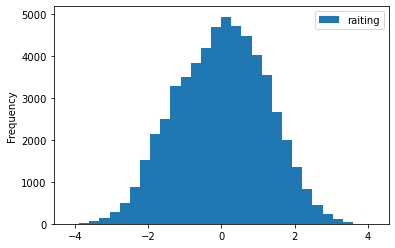

In [ ]:
df_players_rating.plot.hist(bins=30);

In [ ]:
df_questions_complexity

,question_name,tournament_id,complexity
question_id,,,
47720,4772-0,4772,2.486112
47721,4772-1,4772,1.545526
47722,4772-2,4772,-0.032088
47723,4772-3,4772,0.327609
47724,4772-4,4772,2.450376
...,...,...,...
619131,6191-31,6191,-2.676084
619132,6191-32,6191,-0.502384
619133,6191-33,6191,3.117768


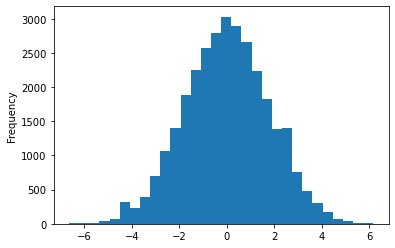

In [ ]:
df_questions_complexity["complexity"].plot.hist(bins=30);

In [ ]:
df_questions_complexity.join(df_tournaments_train_final[["name", "dateStart"]], 
                             how="right", 
                             on="tournament_id").sort_values("complexity").head(10)

,question_name,tournament_id,complexity,name,dateStart
question_id,,,,,
575730,5757-30,5757,-6.648706,Открытый Кубок России,2019-12-05 19:00:00+03:00
575734,5757-34,5757,-6.648705,Открытый Кубок России,2019-12-05 19:00:00+03:00
575714,5757-14,5757,-6.648705,Открытый Кубок России,2019-12-05 19:00:00+03:00
581925,5819-25,5819,-6.459848,ОВСЧ. 2 этап,2019-10-11 00:00:00+03:00
575618,5756-18,5756,-6.422675,Жизнь и время Михаэля К.,2019-10-03 19:00:00+03:00
575633,5756-33,5756,-6.422675,Жизнь и время Михаэля К.,2019-10-03 19:00:00+03:00
575611,5756-11,5756,-6.422675,Жизнь и время Михаэля К.,2019-10-03 19:00:00+03:00
57185,5718-5,5718,-6.420759,Топ-1000,2019-11-07 00:05:00+03:00
571818,5718-18,5718,-6.420759,Топ-1000,2019-11-07 00:05:00+03:00


In [ ]:
df_questions_complexity.join(df_tournaments_train_final[["name", "dateStart"]], 
                             how="right", 
                             on="tournament_id").sort_values("complexity", ascending=False).head(10)

,question_name,tournament_id,complexity,name,dateStart
question_id,,,,,
57026,5702-6,5702,6.167806,(а)Синхрон-lite. Лига старта. Эпизод IX,2019-11-01 00:05:00+03:00
60081,6008-1,6008,6.163668,Малый кубок Физтеха,2019-10-26 12:30:00+03:00
50134,5013-4,5013,6.025259,(а)Синхрон-lite. Лига старта. Эпизод V,2019-04-05 12:00:00+03:00
5564100,5564-100,5564,5.903206,Молодёжный чемпионат Нижегородской области,2019-02-01 00:00:00+03:00
50124,5012-4,5012,5.899980,Школьный Синхрон-lite. Выпуск 2.5,2019-04-05 12:00:00+03:00
564423,5644-23,5644,5.892478,Школьный чемпионат России,2019-05-02 09:00:00+03:00
569817,5698-17,5698,5.717358,(а)Синхрон-lite. Лига старта. Эпизод VII,2019-09-01 00:05:00+03:00
60085,6008-5,6008,5.679500,Малый кубок Физтеха,2019-10-26 12:30:00+03:00
54180,5418-0,5418,5.637225,Зеркало Альпийского Эдельвейса,2019-10-04 19:00:00+03:00


#### Расчет влияния прошлых турниров

In [ ]:
df_tournaments_raiting = df_questions_complexity.groupby("tournament_id").mean("comlexity").join(
    df_tournaments_train_final[["name"]]).sort_values("complexity")

df_tournaments_raiting["complexity"] = df_tournaments_raiting["complexity"].apply(lambda x: x * -1) 
df_tournaments_raiting.head(10)

,complexity,name
tournament_id,,
6149,4.412203,Чемпионат Санкт-Петербурга. Первая лига
5928,2.260397,Угрюмый Ёрш
5684,2.129421,Синхрон высшей лиги Москвы
5159,2.031501,Первенство правого полушария
6101,1.945295,Воображаемый музей
5587,1.759662,Записки охотника
5025,1.685885,Кубок городов
5693,1.650277,Знание – Сила VI
5083,1.646238,Ускользающая сова


In [ ]:
df_tournaments_raiting.tail(10)

,complexity,name
tournament_id,,
5313,-1.983993,(а)Синхрон-lite. Лига старта. Эпизод VI
5936,-1.993495,Школьная лига. I тур.
5011,-2.033112,(а)Синхрон-lite. Лига старта. Эпизод IV
5457,-2.041902,Студенческий чемпионат Калининградской области
5438,-2.124293,Синхрон Лиги Разума
5012,-2.148501,Школьный Синхрон-lite. Выпуск 2.5
5698,-2.223067,(а)Синхрон-lite. Лига старта. Эпизод VII
5702,-2.239016,(а)Синхрон-lite. Лига старта. Эпизод IX
5009,-2.270218,(а)Синхрон-lite. Лига старта. Эпизод III


In [ ]:
min_com = df_tournaments_raiting["complexity"].min()
df_tournaments_raiting["complexity"] = df_tournaments_raiting["complexity"].apply(
    lambda x: x + abs(min_com))
max_com = df_tournaments_raiting["complexity"].max()
df_tournaments_raiting["complexity"] = df_tournaments_raiting["complexity"].apply(
    lambda x: x/max_com + 1)
df_tournaments_raiting

,complexity,name
tournament_id,,
6149,2.000000,Чемпионат Санкт-Петербурга. Первая лига
5928,1.687428,Угрюмый Ёрш
5684,1.668402,Синхрон высшей лиги Москвы
5159,1.654178,Первенство правого полушария
6101,1.641656,Воображаемый музей
...,...,...
5012,1.046990,Школьный Синхрон-lite. Выпуск 2.5
5698,1.036158,(а)Синхрон-lite. Лига старта. Эпизод VII
5702,1.033841,(а)Синхрон-lite. Лига старта. Эпизод IX


In [ ]:
def get_players_experience(train_set, df_tournaments_raiting, train_players_id_index):
  
  train_players_experience = train_players_id_index.copy()
  for key in train_players_experience.keys():
    train_players_experience[key] = []
    
  for tournament_data in train_set:
    number_of_comands = len(tournament_data["teams_data"])
    tournament_id = tournament_data["id"]
    tournament_raiting = df_tournaments_raiting["complexity"][tournament_id]
    team_data_positions = []

    for team_data in tournament_data["teams_data"]:
      team_data_positions.append(team_data["position"])
    
    pos_max = max(team_data_positions)

    for team_data in tournament_data["teams_data"]:
      for player_id in team_data["players_id"]:
        train_players_experience[player_id].append((1-(team_data["position"]/pos_max)) * tournament_raiting)
         
  for key in train_players_experience.keys():
    train_players_experience[key] = sum(train_players_experience[key])/len(train_players_experience[key])
  
  df_train_players_experience = pd.DataFrame.from_dict(train_players_experience, orient='index', columns=["exp"])
  return df_train_players_experience

In [ ]:
df_train_players_experience = get_players_experience(train_set, 
                                                     df_tournaments_raiting, 
                                                     train_players_id_index)

df_train_players_rexp = df_players_rating.join(
    df_players_data).sort_values('raiting', ascending=False).join(df_train_players_experience)

min_rait = df_train_players_rexp["raiting"].min()
df_train_players_rexp["raiting"] = df_train_players_rexp["raiting"].apply(
    lambda x: x + abs(min_rait)
)
max_rait = df_train_players_rexp["raiting"].max()
df_train_players_rexp["raiting"] = df_train_players_rexp["raiting"].apply(
    lambda x: x/max_rait    
)

In [ ]:
df_train_players_rexp

,raiting,name,patronymic,surname,exp
player_id,,,,,
27403,1.000000,Максим,Михайлович,Руссо,1.400930
4270,0.984772,Александра,Владимировна,Брутер,1.383407
28751,0.979336,Иван,Николаевич,Семушин,1.391600
27822,0.968778,Михаил,Владимирович,Савченков,1.375525
30270,0.959135,Сергей,Леонидович,Спешков,1.376009
...,...,...,...,...,...
209401,0.048964,Михаил,Максимович,Казарин,0.011335
209400,0.048963,Илья,Владиславович,Шапуров,0.011335
203842,0.045484,Вероника,Андреевна,Балакина,0.007774


In [ ]:
def from_model_to_rexp_df(lr_model, 
                          train_players_ids,
                          train_set, 
                          df_tournaments_train_final, 
                          df_players_data, 
                          train_players_id_index):
  """
  weird function for getting rexp dataframe during EM steps
  """

  df_questions_complexity = pd.DataFrame({'question_id':list(map(lambda x: int(x.replace("-", "")), train_questions_ids)),
                                    'question_name': train_questions_ids,
                                    'tournament_id': list(map(lambda x: tuple(map(int, x.split("-")))[0], train_questions_ids)),
                                    'complexity': lr_model.coef_[0][len(train_players_ids):]}).set_index('question_id')
  df_players_rating = pd.DataFrame({'player_id': train_players_ids,
                                    'raiting': lr_model.coef_[0][:len(train_players_ids)]}).set_index('player_id')
                                
  df_tournaments_raiting = df_questions_complexity.groupby("tournament_id").mean("comlexity").join(
      df_tournaments_train_final[["name"]]).sort_values("complexity")

  df_tournaments_raiting["complexity"] = df_tournaments_raiting["complexity"].apply(lambda x: x * -1) 

  min_com = df_tournaments_raiting["complexity"].min()
  df_tournaments_raiting["complexity"] = df_tournaments_raiting["complexity"].apply(
      lambda x: x + abs(min_com))
  max_com = df_tournaments_raiting["complexity"].max()
  df_tournaments_raiting["complexity"] = df_tournaments_raiting["complexity"].apply(
      lambda x: x/max_com + 1)

  df_train_players_experience = get_players_experience(train_set, 
                                                      df_tournaments_raiting, 
                                                      train_players_id_index)

  df_train_players_rexp = df_players_rating.join(
      df_players_data).sort_values('raiting', ascending=False).join(df_train_players_experience)

  min_rait = df_train_players_rexp["raiting"].min()
  df_train_players_rexp["raiting"] = df_train_players_rexp["raiting"].apply(
      lambda x: x + abs(min_rait)
  )
  max_rait = df_train_players_rexp["raiting"].max()
  df_train_players_rexp["raiting"] = df_train_players_rexp["raiting"].apply(
      lambda x: x/max_rait    
  )
  return df_train_players_rexp


### Task 3

Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:
* предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;
* в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров.


Для расчета качества предлагаается сравнить три рейтинга для команд с регулируемым влиянием опыта игроков в предыдущих турнирах расчитанного в предыдущем пункте. Каждый рейтинг представляет собой усредненный рейтинг по игрокам команды. Первый рейтинг представляет собой веса модели полученные на 2 шаге. Второй рейтинг более унифицированный, так как состоит в вероятности ответа игрока на вопрос средней сложности. Третий вариант расчета рейтинга состоит в получении среднего значения первых двух. Так же к каждому из рейтингов прибавляется опыт игрока умноженный на регулируемый коэффициент.

In [ ]:
def get_test_standings(lr_model, 
                      train_players_ids, 
                      train_questions_ids, 
                      test_set,
                      train_set,
                      df_tournaments_train_final, 
                      df_players_data,
                      test_players_ids, 
                      train_players_id_index, 
                      exp_weight = 0):

  # df_players_rating = pd.DataFrame({'player_id': train_players_ids,
                                  # 'raiting': model.coef_[0][:len(train_players_ids)]}).set_index('player_id')
  df_train_players_rexp_ = from_model_to_rexp_df(lr_model, 
                                                train_players_ids,
                                                train_set, 
                                                df_tournaments_train_final, 
                                                df_players_data, 
                                                train_players_id_index)

  middle_question = np.abs(lr_model.coef_[0][len(train_players_ids):]).min()
  question_index = np.where(abs(lr_model.coef_[0][len(train_players_ids):]) == middle_question)
  middle_index = question_index[0][0]

  X_columns = len(train_players_ids) + len(train_questions_ids)

  questions_shift = len(train_players_ids)
  question_idx = middle_index + questions_shift

  train_players_ids_set = set(train_players_ids)

  test_results = {}

  for tournament_data in tqdm(test_set):

    tournament_results = {}

    for team_data in tournament_data["teams_data"]:
      true_position = team_data["position"]
      team_players = []
      X_rows = 0 
      # список для расчета на весах модели
      weights_skill = []
      players_exp = []

      # проверяем наличие игроков в обучающей выборке
      for player in team_data["players_id"]:
        if player in train_players_ids_set:
          team_players.append(player)
      if len(team_players) != 0:

        # строим разреженную матрицу по команде
        X_rows = len(team_players)
        X_test = lil_matrix((X_rows, X_columns), dtype=np.int8)

        for n_row, player_id in enumerate(team_players):
          i_player = train_players_id_index[player_id]
          X_test[n_row, i_player] = 1
          X_test[n_row, question_idx] = 1

          # получаем рейтинг игроков из предыдущего пункта для подхода на весах
          weights_skill.append(df_train_players_rexp_["raiting"][player_id])
          
          # получаем значение опыта игроков
          players_exp.append(df_train_players_rexp_["exp"][player_id])

        # считаем рейтинг на основе среднего вопроса
        predicted_skill = lr_model.predict_proba(X_test)[:,1]
        predicted_skill = np.full(predicted_skill.shape, 1 - np.prod(1 - predicted_skill))
        
        # считаем рейтинг для команды
        team_skill_question = np.array(list(map(
            lambda x, z: x + exp_weight * z, predicted_skill, players_exp))).mean()
        team_skill_weights = np.array(list(map(
            lambda y, z: y + exp_weight * z, weights_skill, players_exp))).mean()
        team_skill_both = np.array(list(map(
            lambda x, y, z: ((x + y)/2) + exp_weight * z, predicted_skill, weights_skill, players_exp))).mean()

        team_raitings = {"middle-question":team_skill_question,
                        "model-weights":team_skill_weights,
                        "both":team_skill_both,
                        "true-position":true_position
                        }

        tournament_results[team_data["team_id"]] = team_raitings

    test_results[tournament_data["id"]] = tournament_results
  return test_results

def get_score(standings, verbose=0):

  spearman_correlations = {"middle-question":[],
                            "model-weights":[],
                            "both":[]}
  kendall_correlations = {"middle-question":[],
                          "model-weights":[],
                          "both":[]}
  mode_list = ["middle-question", "model-weights", "both"]

  for tournament_standings in standings.values():
    prediction = {"middle-question":[],
                  "model-weights":[],
                  "both":[]}
    true_position = []
    for team_standing in tournament_standings.values():
      true_position.append(team_standing["true-position"])
      for mode in mode_list:
        prediction[mode].append(team_standing[mode])
    
    for mode in mode_list:
      spearman_correlations[mode].append(spearmanr(prediction[mode], true_position)[0])
      kendall_correlations[mode].append(kendalltau(prediction[mode], true_position)[0])

  kendall_score = {}
  spearman_score = {}
  for mode in mode_list:
    spearman_score[mode] = np.array(list(filter(lambda v: v==v, spearman_correlations[mode]))).mean()
    kendall_score[mode] = np.array(list(filter(lambda v: v==v, kendall_correlations[mode]))).mean()
    if verbose == 1:
      print(mode)
      print("Корреляция Спирмена:", abs(spearman_score[mode]))
      print("Корреляция Кендалла:", abs(kendall_score[mode]))
  return spearman_score, kendall_score

In [ ]:
# Сравним рейтинги
weights_coef_list = [0, 0.3, 0.6, 1]
for coef in weights_coef_list:
  standings = get_test_standings(lr_model, 
                                 train_players_ids, 
                                 train_questions_ids, 
                                 test_set,
                                 train_set,
                                 df_tournaments_train_final, 
                                 df_players_data,
                                 test_players_ids, 
                                 train_players_id_index,
                                 exp_weight = coef)
  print("Коэффициент:", coef)
  _,_ = get_score(standings, verbose=1)

  0%|          | 0/169 [00:00<?, ?it/s]

Коэффициент: 0
middle-question
Корреляция Спирмена: 0.8045981384765374
Корреляция Кендалла: 0.6466741383795988
model-weights
Корреляция Спирмена: 0.7795177014656948
Корреляция Кендалла: 0.6241814572893263
both
Корреляция Спирмена: 0.8123672128220889
Корреляция Кендалла: 0.6538460875328117


  0%|          | 0/169 [00:00<?, ?it/s]

Коэффициент: 0.3
middle-question
Корреляция Спирмена: 0.799816701190276
Корреляция Кендалла: 0.638504846496985
model-weights
Корреляция Спирмена: 0.7625275798193866
Корреляция Кендалла: 0.6047939386110205
both
Корреляция Спирмена: 0.7924056257784906
Корреляция Кендалла: 0.6316063680331747


  0%|          | 0/169 [00:00<?, ?it/s]

Коэффициент: 0.6
middle-question
Корреляция Спирмена: 0.7922272035787644
Корреляция Кендалла: 0.6311277010630898
model-weights
Корреляция Спирмена: 0.7529092894507394
Корреляция Кендалла: 0.5946917218051566
both
Корреляция Спирмена: 0.7815604120683362
Корреляция Кендалла: 0.6209789964802473


  0%|          | 0/169 [00:00<?, ?it/s]

Коэффициент: 1
middle-question
Корреляция Спирмена: 0.7811364784575365
Корреляция Кендалла: 0.6188806989021054
model-weights
Корреляция Спирмена: 0.745512509855497
Корреляция Кендалла: 0.5868257773427391
both
Корреляция Спирмена: 0.7735338488795378
Корреляция Кендалла: 0.6134288044523983


Хотя модель использующая оба подхода показала лучший результат она менее устойчива и на другой тестовой выборке может показать результат хуже чем подход использующий значения рейтингов полученные на среднем вопросе.

### Task 4

Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:
* предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;
* разработайте EM-схему для обучения этой модели, реализуйте её в коде;
* обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.


In [ ]:
model_em = deepcopy(lr_model)
X_train_em = vstack([X_train, X_train], dtype=np.int8)
y_train_em =np.concatenate((np.full(X_train.shape[0], 1), np.full(X_train.shape[0], 0)))

In [ ]:
def E_step(model_em, X_train_em, y_train_em, train_set):
  weights = np.zeros(X_train_em.shape[0])
  
  pred = model_em.predict_proba(X_train_em)
  
  X_rows = int(X_train_em.shape[0]/2)
  n_row = 0

  for tournament_data in tqdm(train_set):
    for team_data in tournament_data["teams_data"]:
      num_players = team_data["n_players"]
      for i_question in range(tournament_data["n_questions"]):
        true_y = team_data["mask"][i_question]
        if true_y == 0:
          weights[n_row : n_row + num_players] = 0
          weights[X_rows + n_row : X_rows + n_row + num_players] = 1
        else:
          p_i = pred[n_row : n_row + num_players, 1]
          p_i = p_i / (1 - (1 - p_i).prod())
          p_i = np.clip(p_i, 0, 1)
          
          weights[n_row : n_row + num_players] = list(p_i)
          weights[X_rows + n_row : X_rows + n_row + num_players] = list(1 - p_i)

        n_row += num_players
  return weights

def M_step(weights, X_train_em, y_train_em):
  model_em = LogisticRegression(solver="saga")
  model_em.fit(X_train_em, y_train_em, sample_weight=weights)
  return model_em

In [ ]:
EM_steps = 100
spearman_history = []
kendall_history = []
for i in tqdm(range(EM_steps)):
  logging.info(f"STEP E-{i+1} processing...")
  weights = E_step(model_em, X_train_em, y_train_em, train_set)
  logging.info(f"STEP M-{i+1} processing...")
  model_em = M_step(weights, X_train_em, y_train_em)
  logging.info("Gettig scores...")
  standings = get_test_standings(model_em, 
                                 train_players_ids, 
                                 train_questions_ids, 
                                 test_set,
                                 train_set,
                                 df_tournaments_train_final, 
                                 df_players_data,
                                 test_players_ids, 
                                 train_players_id_index,
                                 exp_weight = 0)
  spearman_score, kendall_score = get_score(standings, verbose=0)
  print("Корреляция Спирмена:", abs(spearman_score["both"]))
  print("Корреляция Кендалла:", abs(kendall_score["both"]))
  if (len(spearman_history) != 0 and (spearman_history[-1] > abs(spearman_score["both"]) or 
                                      kendall_history[-1] > abs(kendall_score["both"]))):
    break

  spearman_history.append(abs(spearman_score["both"]))
  kendall_history.append(abs(kendall_score["both"]))
  

  0%|          | 0/100 [00:00<?, ?it/s]

2022-05-02 03:40:37,600 | INFO : STEP E-1 processing...


  0%|          | 0/663 [00:00<?, ?it/s]

2022-05-02 03:41:26,009 | INFO : STEP M-1 processing...
2022-05-02 03:52:24,860 | INFO : Gettig scores...


  0%|          | 0/169 [00:00<?, ?it/s]

Корреляция Спирмена: 0.8100751980984873
Корреляция Кендалла: 0.6520327537332664
2022-05-02 03:52:36,252 | INFO : STEP E-2 processing...


  0%|          | 0/663 [00:00<?, ?it/s]

2022-05-02 03:53:23,486 | INFO : STEP M-2 processing...
2022-05-02 04:06:30,621 | INFO : Gettig scores...


  0%|          | 0/169 [00:00<?, ?it/s]

Корреляция Спирмена: 0.8110346753406726
Корреляция Кендалла: 0.6531535264808271
2022-05-02 04:06:41,834 | INFO : STEP E-3 processing...


  0%|          | 0/663 [00:00<?, ?it/s]

2022-05-02 04:07:27,819 | INFO : STEP M-3 processing...
2022-05-02 04:18:55,500 | INFO : Gettig scores...


  0%|          | 0/169 [00:00<?, ?it/s]

Корреляция Спирмена: 0.8115110605593688
Корреляция Кендалла: 0.6538155590149145
2022-05-02 04:19:06,415 | INFO : STEP E-4 processing...


  0%|          | 0/663 [00:00<?, ?it/s]

2022-05-02 04:19:53,055 | INFO : STEP M-4 processing...
2022-05-02 04:31:56,876 | INFO : Gettig scores...


  0%|          | 0/169 [00:00<?, ?it/s]

Корреляция Спирмена: 0.8108264579735178
Корреляция Кендалла: 0.6536469551965032


Хотя результат EM алгоритма хуже изначального интересно было бы сравнить его на других тестовых наборах или парах обучающих и тестовых наборов (предсказывать каждый последующий года основываясь на фиксированной обучающей выборке или двигать обучающую и тестовую выборку вместе)

### Task 5

А что там с вопросами? Постройте “рейтинг-лист” турниров по сложности вопросов. Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть сложные вопросы, а на турнирах для школьников — простые)? Если будет интересно: постройте топ сложных и простых вопросов со ссылками на конкретные записи в [базе вопросов ЧГК](http://db.chgk.info) (это чисто техническое дело, тут никакого ML нету)

Поскольку данное задание было сделано во втором пункте скопирую код от туда. Тут минимальные значения сложности вопроса соответствуют самым сложным вопросам.


In [ ]:
df_questions_complexity.join(df_tournaments_train_final[["name", "dateStart"]], 
                             how="right", 
                             on="tournament_id").sort_values("complexity").head(15)

,question_name,tournament_id,complexity,name,dateStart
question_id,,,,,
575734,5757-34,5757,-6.648735,Открытый Кубок России,2019-12-05 19:00:00+03:00
575730,5757-30,5757,-6.648734,Открытый Кубок России,2019-12-05 19:00:00+03:00
575714,5757-14,5757,-6.648734,Открытый Кубок России,2019-12-05 19:00:00+03:00
581925,5819-25,5819,-6.459878,ОВСЧ. 2 этап,2019-10-11 00:00:00+03:00
575611,5756-11,5756,-6.422705,Жизнь и время Михаэля К.,2019-10-03 19:00:00+03:00
575618,5756-18,5756,-6.422704,Жизнь и время Михаэля К.,2019-10-03 19:00:00+03:00
575633,5756-33,5756,-6.422704,Жизнь и время Михаэля К.,2019-10-03 19:00:00+03:00
57185,5718-5,5718,-6.420787,Топ-1000,2019-11-07 00:05:00+03:00
571818,5718-18,5718,-6.420787,Топ-1000,2019-11-07 00:05:00+03:00


In [ ]:
df_questions_complexity.join(df_tournaments_train_final[["name", "dateStart"]], 
                             how="right", 
                             on="tournament_id").sort_values("complexity").tail(15)

,question_name,tournament_id,complexity,name,dateStart
question_id,,,,,
58410,5841-0,5841,5.404868,Серия Гран-при. 2 этап. Гран-при Казахстана,2019-10-24 19:00:00+03:00
588625,5886-25,5886,5.425740,Кубок Сухого,2019-09-28 12:00:00+03:00
548521,5485-21,5485,5.466988,Буслик,2019-03-30 12:00:00+03:00
59801,5980-1,5980,5.490170,Большая перемена,2019-10-19 14:00:00+03:00
61478,6147-8,6147,5.509843,Открытый зимний чемпионат ТИУ,2019-12-10 17:00:00+03:00
53131,5313-1,5313,5.564102,(а)Синхрон-lite. Лига старта. Эпизод VI,2019-06-05 00:00:00+03:00
54180,5418-0,5418,5.637197,Зеркало Альпийского Эдельвейса,2019-10-04 19:00:00+03:00
60085,6008-5,6008,5.679467,Малый кубок Физтеха,2019-10-26 12:30:00+03:00
569817,5698-17,5698,5.717319,(а)Синхрон-lite. Лига старта. Эпизод VII,2019-09-01 00:05:00+03:00


In [ ]:
df_tournaments_raiting.head(15)

,complexity,name
tournament_id,,
6149,2.000000,Чемпионат Санкт-Петербурга. Первая лига
5928,1.687428,Угрюмый Ёрш
5684,1.668403,Синхрон высшей лиги Москвы
5159,1.654179,Первенство правого полушария
6101,1.641656,Воображаемый музей
5587,1.614691,Записки охотника
5025,1.603975,Кубок городов
5693,1.598802,Знание – Сила VI
5083,1.598215,Ускользающая сова


In [ ]:
df_tournaments_raiting.tail(15)

,complexity,name
tournament_id,,
5954,1.100213,Школьная лига. II тур.
5008,1.097268,Школьный Синхрон-lite. Выпуск 2.3
6008,1.085351,Малый кубок Физтеха
5704,1.077033,(а)Синхрон-lite. Лига старта. Эпизод X
5955,1.076172,Школьная лига. III тур.
5313,1.070886,(а)Синхрон-lite. Лига старта. Эпизод VI
5936,1.069507,Школьная лига. I тур.
5011,1.063751,(а)Синхрон-lite. Лига старта. Эпизод IV
5457,1.062474,Студенческий чемпионат Калининградской области


Полученные результаты соответствуют здравому смыслу